# Multi-Digit Number recognition from Street View Images

The final project of Udacity's deep learning course is to design an app that can recognize multi-digit numbers in real-world images. The core of this app is a neural network able to take whole images as an input and recognize the number in it.

My objective here is a little simpler : The network will not be embedded in an app, and the pictures will be slightly processed. 

It wil be trained on the street view house numbers dataset (http://ufldl.stanford.edu/housenumbers/). The solution is largely based on the paper by Google researchers[1]. 


Let's get started!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import gzip
from IPython.display import display, Image
from scipy import ndimage, misc
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## Concatenated MNIST image

I will first start with a simpler problem using the MNIST dataset (http://yann.lecun.com/exdb/mnist/). The dataset contains images of single handwritten digit, and the corresponding label. To work on multi-digit images, I will concatenate 3 images horizontally. This will make the images non square but that should not be a problem for convolutional nets. 

### Download MNIST data

First let's get the data and transform it into numpy arrays. The arrays will have dimensions $[N, dv, dh, nc]$, where $N$ is the number of images in the dataset, $dv$ is the vertical dimension of the figure in pixels, $dh$ is the horizontal dimension in pixels, and $nc$ is the numbers of *channels*, which is 1 for bw pictures and 3 for rgb pictures.

In [2]:
last_percent_reported = None
data_root = './data/' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(url, filename, expected_bytes=None, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if expected_bytes:
      if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
      else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

url = 'http://yann.lecun.com/exdb/mnist/'
mnist_train_data_filename = maybe_download(url, 'train-images-idx3-ubyte.gz', 9912422)
mnist_train_labels_filename = maybe_download(url, 'train-labels-idx1-ubyte.gz', 28881)
mnist_test_data_filename = maybe_download(url, 't10k-images-idx3-ubyte.gz', 1648877) 
mnist_test_labels_filename = maybe_download(url, 't10k-labels-idx1-ubyte.gz', 4542)

Found and verified ./data/train-images-idx3-ubyte.gz
Found and verified ./data/train-labels-idx1-ubyte.gz
Found and verified ./data/t10k-images-idx3-ubyte.gz
Found and verified ./data/t10k-labels-idx1-ubyte.gz


In [3]:
IMAGE_SIZE = 28

def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].
  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
    return data

def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
  return labels

# Extract it into np arrays.
mnist_train_data = extract_data(mnist_train_data_filename, 60000)
mnist_train_labels = extract_labels(mnist_train_labels_filename, 60000)
mnist_test_data = extract_data(mnist_test_data_filename, 10000)
mnist_test_labels = extract_labels(mnist_test_labels_filename, 10000)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


Let's plot randomly some figures to see what they look like. 

7


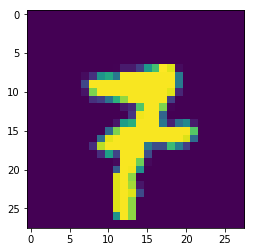

3


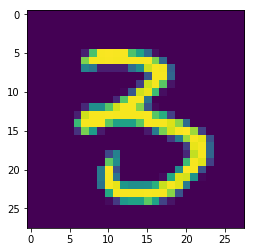

5


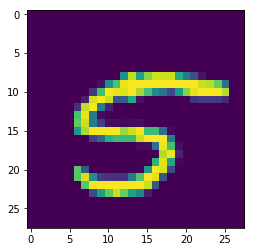

0


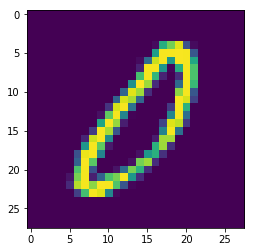

1


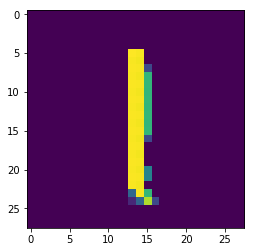

6


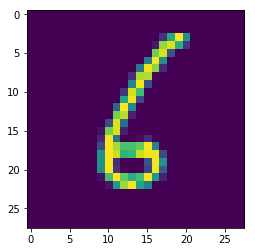

3


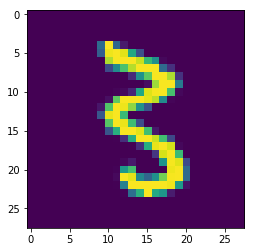

4


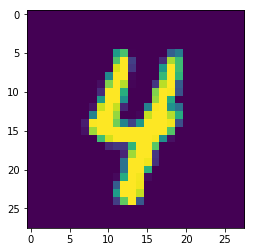

9


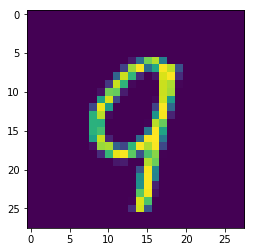

5


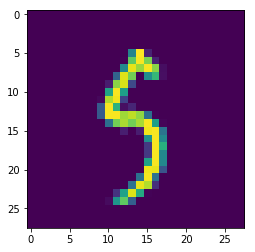

In [4]:
nimgs = 10 
for i in np.random.randint(0,mnist_train_data.shape[0],nimgs):
    print(mnist_train_labels[i])
    plt.imshow(mnist_train_data[i,:,:,0])
    plt.show()

### Generate input data and labels

Now let's create a random dataset of 3-digits figures by concatenating 3 randomly selected one-digit pictures. We also create the labels which will be vectors of length 3, with one component for each of the three digits.

In [5]:
train_set_size = 60000
data = np.zeros((train_set_size, IMAGE_SIZE, IMAGE_SIZE*3, 1), dtype=np.float32)
labels = np.zeros((train_set_size,3),dtype=np.int32)
for i in range(train_set_size):
    [i1,i2,i3] = np.random.randint(0,mnist_train_data.shape[0],3)
    for j in range(28):
        data[i,j,:,0] = np.concatenate([mnist_train_data[i1,j,:,0],
                                        mnist_train_data[i2,j,:,0],
                                        mnist_train_data[i3,j,:,0]],axis=0) 
        
    labels[i,0] = mnist_train_labels[i1]
    labels[i,1] = mnist_train_labels[i2]
    labels[i,2] = mnist_train_labels[i3]

Let's visualize the results :

[2 4 1]


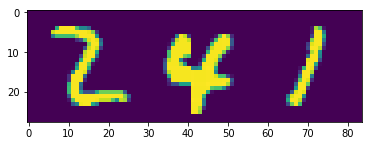

[5 3 1]


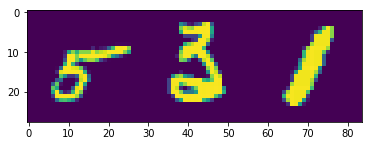

[3 0 2]


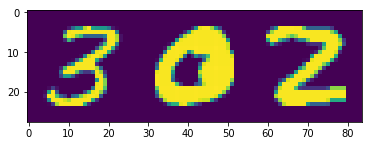

[9 3 6]


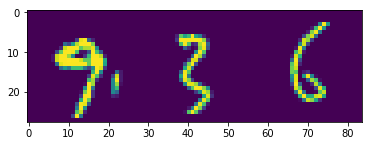

[8 5 7]


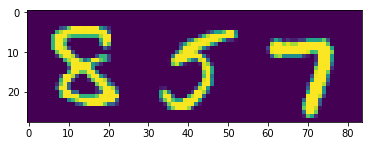

In [6]:
nimgs = 5 
for i in np.random.randint(0,data.shape[0],nimgs):
    print(labels[i,:])
    plt.imshow(data[i,:,:,0])
    plt.show()

We will need to split the training set into a set used for the training only, and a validation set used to determine if the gradient descent is converging properly. 

In [8]:
indices = np.random.permutation(train_set_size)
training_idx, valid_idx = indices[5000:], indices[:5000]
train_dataset, valid_dataset = data[training_idx,:], data[valid_idx,:]
train_labels, valid_labels = labels[training_idx,:], labels[valid_idx,:]

Now we create a test set, which will be used only at the end of the training.

In [9]:
test_set_size = 5000
test_dataset = np.zeros((test_set_size, IMAGE_SIZE, IMAGE_SIZE*3, 1),dtype=np.float32)
test_labels = np.zeros((test_set_size,3,),dtype=np.int32)
for i in range(test_set_size):
    [i1, i2, i3] = np.random.randint(0,mnist_test_data.shape[0],3)
    for j in range(28):
        test_dataset[i,j,:,0] = np.concatenate([mnist_test_data[i1,j,:,0],
                                                mnist_test_data[i2,j,:,0],
                                                mnist_test_data[i3,j,:,0]],axis=0) 
        
    test_labels[i,0] = mnist_test_labels[i1]
    test_labels[i,1] = mnist_test_labels[i2]
    test_labels[i,2] = mnist_test_labels[i3]    

### Create graph architecture

For this simpler problem, we will create a network, with only one convolutional layer, and three softmax output layers : one for each of the three digits in the image. As explained in [1], we can reasonably assume that that each digit in a number is independant of the other. Therefore, instead of a unique softmax classifier with 1000 possible outputs, we can recognize separately each digit and the most likely sequence of digits correspond to the product of the probabilities of each individual digit. The loss function is thus the sum of the cross-entropies of each individual digit.

The weights of the convolutional layer are initiliazed randomly by sampling a gaussian of small variance. The biases and the weights of the output layers can be set to zero as explained in [2]. 

At this stage, I use no pooling, no dropout, and no fully connected layer. 

Finally, to evaluate the performance of the model, we compute both the per-digit accuracy, and the accuracy for the whole sequence of number.

In [7]:
def digit_accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.all(np.argmax(predictions, 2).T == labels, axis=1))/predictions.shape[1])

In [11]:
batch_size = 64
patch_size = 5
depth = 16
num_labels = 10
num_digits = 3
num_hidden = 64
num_channels = 1 # Number of numbers to characterize each pixel. Here we have grey/white pictures, hence 1. 

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE * num_digits, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.01))
  layer1_biases = tf.Variable(tf.zeros([depth]))

  out1_w = tf.Variable(tf.zeros(shape=[IMAGE_SIZE // 2 * IMAGE_SIZE // 2 * num_digits * depth, num_labels]))
  out1_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out2_w = tf.Variable(tf.zeros(shape=[IMAGE_SIZE // 2 * IMAGE_SIZE // 2 * num_digits * depth, num_labels]))
  out2_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out3_w = tf.Variable(tf.zeros(shape=[IMAGE_SIZE // 2 * IMAGE_SIZE // 2 * num_digits * depth, num_labels]))
  out3_b = tf.Variable(tf.zeros(shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    logits1 = tf.matmul(reshape, out1_w) + out1_b
    logits2 = tf.matmul(reshape, out2_w) + out2_b
    logits3 = tf.matmul(reshape, out3_w) + out3_b
    
    return [logits1, logits2, logits3]
  
  # Training computation.
  [logits1, logits2, logits3] = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits1, labels = tf_train_labels[:,0])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits2, labels = tf_train_labels[:,1])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits3, labels = tf_train_labels[:,2])) 
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset)[0]),\
                               tf.nn.softmax(model(tf_train_dataset)[1]),\
                               tf.nn.softmax(model(tf_train_dataset)[2])])
  valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset)[0]),\
                               tf.nn.softmax(model(tf_valid_dataset)[1]),\
                               tf.nn.softmax(model(tf_valid_dataset)[2])])
  test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset)[0]),\
                              tf.nn.softmax(model(tf_test_dataset)[1]),\
                              tf.nn.softmax(model(tf_test_dataset)[2])])

### Train and evaluate the model

In [12]:
num_steps = 10001
minib_acc = []
minib_dig_acc = []
valid_acc = []
valid_dig_acc = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      valid_pred = valid_prediction.eval()  
      score_minib = accuracy(predictions, batch_labels)
      score_dig_minib = digit_accuracy(predictions, batch_labels)
      score_valid = accuracy(valid_pred, valid_labels)
      score_dig_valid = digit_accuracy(valid_pred, valid_labels)
      minib_acc.append(score_minib)
      valid_acc.append(score_valid)
      minib_dig_acc.append(score_dig_minib)
      valid_dig_acc.append(score_dig_valid)
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % score_minib)
      print('Validation accuracy: %.1f%%' % score_valid)
      print('Minibatch char accuracy: %.1f%%' % score_dig_minib)
      print('Validation char accuracy: %.1f%%' % score_dig_valid) 
  test_pred = test_prediction.eval()  
  print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))
  print('Test per-digit accuracy: %.1f%%' % digit_accuracy(test_pred, test_labels))

Initialized
Minibatch loss at step 0: 6.907755
Minibatch accuracy: 0.0%
Validation accuracy: 0.2%
Minibatch char accuracy: 9.4%
Validation char accuracy: 17.7%
Minibatch loss at step 1000: 0.328515
Minibatch accuracy: 90.6%
Validation accuracy: 89.7%
Minibatch char accuracy: 96.9%
Validation char accuracy: 96.4%
Minibatch loss at step 2000: 0.225030
Minibatch accuracy: 92.2%
Validation accuracy: 91.4%
Minibatch char accuracy: 97.4%
Validation char accuracy: 97.0%
Minibatch loss at step 3000: 0.067750
Minibatch accuracy: 100.0%
Validation accuracy: 92.1%
Minibatch char accuracy: 100.0%
Validation char accuracy: 97.3%
Minibatch loss at step 4000: 0.027830
Minibatch accuracy: 100.0%
Validation accuracy: 92.7%
Minibatch char accuracy: 100.0%
Validation char accuracy: 97.5%
Minibatch loss at step 5000: 0.018396
Minibatch accuracy: 100.0%
Validation accuracy: 92.1%
Minibatch char accuracy: 100.0%
Validation char accuracy: 97.3%
Minibatch loss at step 6000: 0.023925
Minibatch accuracy: 98.4%


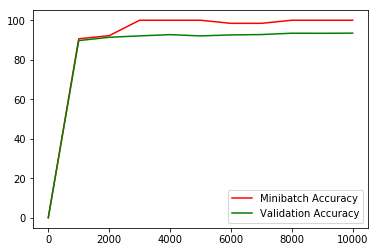

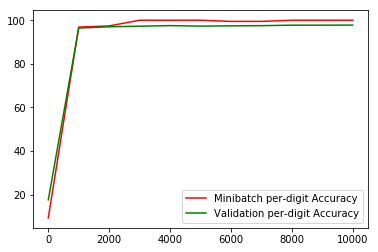

In [13]:
plt.plot(range(0,num_steps+1,1000),minib_acc,'-r',label='Minibatch Accuracy')
plt.plot(range(0,num_steps,1000),valid_acc,'-g', label='Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(range(0,num_steps+1,1000),minib_dig_acc,'-r',label='Minibatch per-digit Accuracy')
plt.plot(range(0,num_steps,1000),valid_dig_acc,'-g', label='Validation per-digit Accuracy')
plt.legend()

There is a bit of over fitting, we could probably improve the results by modifying the network and tuning the parameter, but this is not the goal here. We can now visualize some prediction along with the correct answer.

label: 475
pred:  475


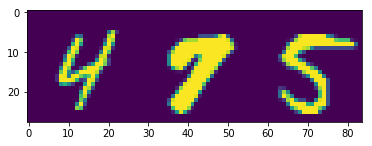

label: 732
pred:  732


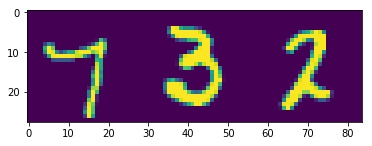

label: 240
pred:  240


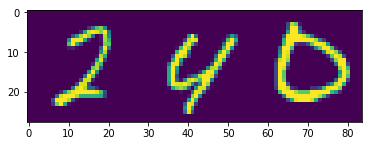

label: 232
pred:  232


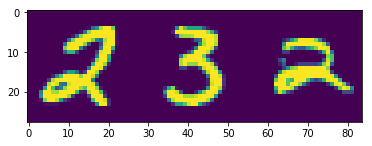

label: 833
pred:  833


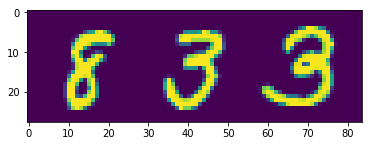

In [14]:
nimgs = 5 
for i in np.random.randint(0,test_dataset.shape[0],nimgs):
    print('label: %d%d%d' %(test_labels[i,0],test_labels[i,1],test_labels[i,2]))
    print('pred:  %d%d%d' %(np.argmax(test_pred[:,i,:],1)[0],
                            np.argmax(test_pred[:,i,:],1)[1],
                            np.argmax(test_pred[:,i,:],1)[2]))
    plt.imshow(test_dataset[i,:,:,0])
    plt.show()

## SVHN dataset

Now we will try to recognize house numbers in Google Street View images. Google has released a dataset of 600 000 labelled images extracted from street views pictures (http://ufldl.stanford.edu/housenumbers/). First let's get the data. 

### Download and extract the data

In [15]:
url = 'http://ufldl.stanford.edu/housenumbers/'
train_filename = maybe_download(url,'train.tar.gz')
test_filename = maybe_download(url,'test.tar.gz')
extra_filename = maybe_download(url,'extra.tar.gz')

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: extra.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


In [16]:
# .tar.gz file extraction function
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
  return data_folders
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

Extracting data for ./data/train. This may take a while. Please wait.
Extracting data for ./data/test. This may take a while. Please wait.
Extracting data for ./data/extra. This may take a while. Please wait.


### Read image structure

The `./data` folder contains all the pictures in png format. Additionnaly, There is one file (`digitStruct.mat`) that contains, for each pictures, the bounding boxes of the digits to be recognized, as well as, for each digit, the corresponding number. This is a matlab file, but the encoding is actually hdf5. To read the content of that file, I will use the following class I found on Github, specifically dedicated to the reading of this kind of file.

In [8]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result


Now let us read the data. The output of this opration is a list of dictionaries, one for each image file. The dictionaries contain two items : 
- the name of the file.
- a list of information about the individual digits in the pictures (bounding boxes and label)

In [9]:
train_folder = os.path.join(data_root, 'train')
test_folder = os.path.join(data_root, 'test')
extra_folder = os.path.join(data_root, 'extra')

print('Reading Training Data')
fin = os.path.join(train_folder, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()
print('Reading Test Data')
fin = os.path.join(test_folder, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()
print('Reading Extra Data')
fin = os.path.join(extra_folder, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

Reading Training Data
Reading Test Data
Reading Extra Data


In [10]:
len(extra_data)

202353

Now we need to read the png images and convert them into numpy matrices. Let's visualize some examples.

(182, 387, 3)


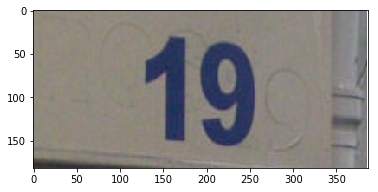

(36, 78, 3)


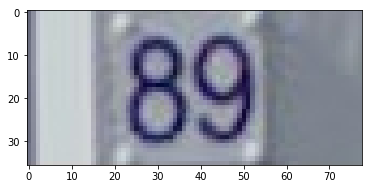

(44, 114, 3)


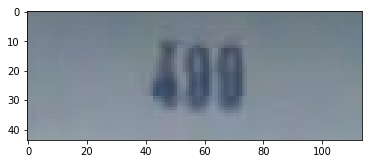

(32, 66, 3)


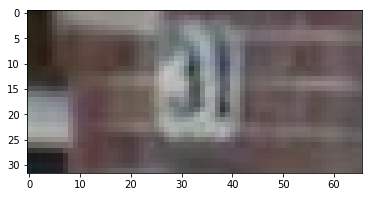

(40, 88, 3)


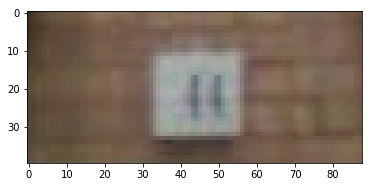

In [11]:
nimgs = 5 
for i in np.random.randint(0,len(train_data),nimgs):
    im = misc.imread('./data/train/'+str(i)+'.png')
    print(im.shape)
    plt.imshow(im)
    plt.show()

### Image pre-processing and datasets preparation

The pictures have different sizes and different number of digits. To feed them into a convnet, we need to pre-process them. We will do this following the procedure described in [1], that is to say : 
- Determine the minimum subimage that include all the bounding boxes of all the images. Note that this step requires the bounding boxes of each digit that are gently provided with the dataset. Without it, we would probably need another network that localizes a digit in a picture.
- crop the image to the subimage determined above, adding some surrounding margin. 
- Rescale the image to a given size. For the present case, we will keep the size of the image reasonable (32x32) to make sure the computation remain feasible. The original paper report a figure size of 54x54. 

Note that the images having different initial sizes will have different scaling factors. 

Furthermore, we restrict ourselves to number with 5 digits at most. To help determine the number of digits in the each picture, each label contains, in addition to the label of each individual digit, the to tal number of digit to identify. There will be thus 5 different outputs to the network : one for the identification of each individual digits.
For number that have less than four digits, we need to include a level *no_number* in the labels, indicating that there is no number for that output. The output classifier will thus be softmax layers with 11 possible outputs.

In [12]:
IMAGE_SIZE = 32

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def set_labels (boxes):
    label=np.ones(5)*10
    num_digits = len(boxes)
    for j in range(num_digits):
        # I realized when visualizing labels that digit 0 is labelled as 10. Hence the modulo operation below.
        label[j]=boxes[j]['label']%10
        
    return label

def compute_global_bbox(boxes):
    '''compute bounding boxes surrounding several digits from the individual bounding boxes.'''
    num_digits = len(boxes)
    tops = []
    lefts = []
    widths = []
    heights = [] 
    for j in range(num_digits):
        tops.append(boxes[j]['top'])
        lefts.append(boxes[j]['left'])
        widths.append(boxes[j]['width'])
        heights.append(boxes[j]['height'])
    # Compute edges of global bouding box. Note that in a pictures, the x axis points downward, hence the 'top' correspond 
    # to the smallest x coordinate in pixels.  
    top = np.int32(min(tops))
    bottom = np.int32(max(tops) + heights[np.argmax(tops)])
    left = np.int32(min(lefts))
    right = np.int32(max(lefts) + widths[np.argmax(lefts)])
    return top, bottom, left, right 

def reduce_image(filename, boxes, output_size):
    '''Read an image from  a png file, compute the bounding box of the number, rescale to a desired size, and convert to 
    single channel (grayscale).'''
    top, bottom, left, right = compute_global_bbox(boxes)
    im = misc.imread(filename)

    # crop to the bouding box. The min and max operation ensure we don't try to crop beyond the image.
    cropped_im = im[max(top,0):min(bottom,im.shape[0]), max(left,0):min(right,im.shape[1])]
    # resize to the desired size
    rescaled_im = misc.imresize(cropped_im,(output_size,output_size))
    # convert to grayscale
    gray_im = rgb2gray(rescaled_im)

    return gray_im


def image_preprocessing(data, folder):
    '''Preprocess the images from the SVHN dataset by croping to a box surrounding the number and rescaling to an appropriate 
       size.
        input: - data : structure containing the filenames, the labels, and the bounding boxes of the individual digits.
               - folder : folder containing the png files.  
        output: - dataset : numpy array of size [num_images, 32, 32, 1] containing the training images
                - labels : numpy array of size [num_images,6] describing the labels. For each image a vector of size 6 
                indicate :
                    [0]: the number of digits in the image
                    [1] to [5] : the identification of the individual digit from 0 to 10. A 10 indicates a missing digit.
                  For example the label : [4,1,2,3,4,10], indicates a number with four digits, the number being 1234.
    '''
    # variable initialization :
    num_images = len(data)
    output_size = IMAGE_SIZE
    num_channels = 1
    dataset = np.ndarray([num_images,output_size,output_size,num_channels],dtype=np.float32)
    labels = np.ndarray([num_images,5],dtype=np.int32)

    # loop on the images
    for i in range(num_images):
        filename = os.path.join(folder,data[i]['filename'])
        boxes = data[i]['boxes']
        num_digits = len(boxes)
        if num_digits>5:
            print('Image # %d has %d digits, skipping.'%(i,num_digits))
            continue
        labels[i,:] = set_labels(boxes)
        # read and resize image. Store in dataset
        im = reduce_image(filename, boxes, output_size)
        adjusted_stddev = max(np.std(im), 1.0/np.sqrt(im.size))# suggestion from tensorflow library
        dataset[i,:,:,0] = (im-np.mean(im, dtype='float32'))/adjusted_stddev
        
    return dataset, labels
    

In [13]:
dataset, labels = image_preprocessing(train_data,train_folder)
test_dataset, test_labels = image_preprocessing(test_data,test_folder)

Image # 29929 has 6 digits, skipping.


In [14]:
# Remove the image that has more than 5 digits.
dataset = np.delete(dataset, 29929, axis=0)
labels = np.delete(labels, 29929, axis=0)

Let's visualize the results for some random images :

label:  [ 7  3 10 10 10]


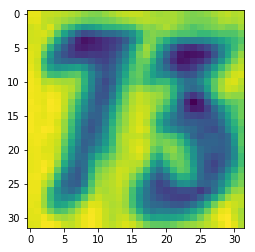

label:  [ 3 10 10 10 10]


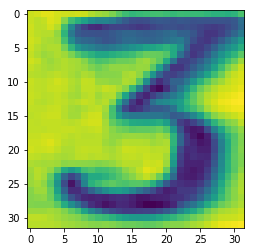

label:  [ 3  0  6 10 10]


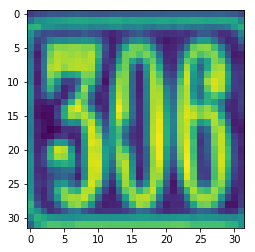

label:  [ 5  9 10 10 10]


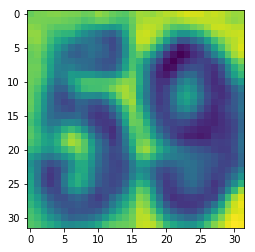

label:  [ 4  8 10 10 10]


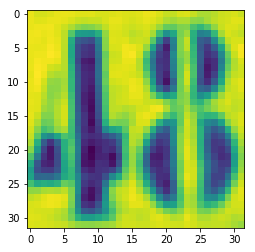

In [15]:
nimgs = 5 
for i in np.random.randint(0,dataset.shape[0],nimgs):
    print('label: ',labels[i,:])
    plt.imshow(dataset[i,:,:,0])
    plt.show()

We can readily appreciate how complicated the task is likely to be. The number are scaled much differently, some are white on a dark background, some are black on a clear background, some can barely be identified by a human. The original size of the dataset is pretty small. This will likely not be enough, and we will need to use the extra dataset also provided by google. 

In [16]:
indices = np.random.permutation(dataset.shape[0])
training_idx, valid_idx = indices[5000:], indices[:5000]
train_dataset, valid_dataset = dataset[training_idx,:], dataset[valid_idx,:]
train_labels, valid_labels = labels[training_idx,:], labels[valid_idx,:]

Finally, let us define a new accuracy measure.

### Define Network architecture

The network architecture is made of three convolutional layers, followed by one fully connected layer. Max pooling is applied after each convolutional layer, and dropout is used on the convolutional and hidden layers outputs during training. During training, we use dropout to reduce overfitting. A regularization term is added to the loss function. Local response normalization with default parameter is applied after each convolutional layer.

In [36]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_labels = 11
max_num_digits = 5
num_hidden_1 = 128
num_hidden_2 = 64
num_channels = 1 # Number of numbers to characterize each pixel. Here we have grey/white pictures, hence 1. 
lam = 0.01*batch_size/train_dataset.shape[0]
keep_prob=0.8
graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE , num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  #layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.01))
  layer1_biases = tf.Variable(tf.constant(0.0, shape=[depth1]))
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  #layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.01))
  layer2_biases = tf.Variable(tf.constant(0.0, shape=[depth2]))
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, depth3],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  #layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev=0.01))
  layer3_biases = tf.Variable(tf.constant(0.0, shape=[depth3]))
  layer4_weights = tf.get_variable("W4", shape=[IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * depth3, num_hidden_1],\
           initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden_1]))
  layer5_weights = tf.get_variable("W5", shape=[num_hidden_1, num_hidden_2],\
           initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden_2]))

  out1_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out1_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out2_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out2_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out3_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out3_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out4_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out4_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out5_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out5_b = tf.Variable(tf.zeros(shape=[num_labels]))

  # Model.
  def model(data,keep_prob=keep_prob):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding = 'SAME')
    relu1 = tf.nn.local_response_normalization(tf.nn.relu(conv1 + layer1_biases))    
    pool1 = tf.nn.dropout(tf.nn.max_pool(relu1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'),keep_prob)
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding = 'SAME')
    relu2 = tf.nn.local_response_normalization(tf.nn.relu(conv2 + layer2_biases))
    pool2 = tf.nn.dropout(tf.nn.max_pool(relu2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'),keep_prob)
    conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, 1, 1, 1], padding = 'SAME')
    relu3 = tf.nn.local_response_normalization(tf.nn.relu(conv3 + layer3_biases))
    pool3 = tf.nn.dropout(tf.nn.max_pool(relu3, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'),keep_prob)
    shape = pool3.get_shape().as_list()
    reshape = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape,layer4_weights)+layer4_biases),keep_prob)
    hidden_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden_1,layer5_weights)+layer5_biases),keep_prob)
    logits1 = tf.matmul(hidden_2, out1_w) + out1_b
    logits2 = tf.matmul(hidden_2, out2_w) + out2_b
    logits3 = tf.matmul(hidden_2, out3_w) + out3_b
    logits4 = tf.matmul(hidden_2, out4_w) + out4_b
    logits5 = tf.matmul(hidden_2, out5_w) + out5_b
    
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)    
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits1, labels = tf_train_labels[:,0])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits2, labels = tf_train_labels[:,1])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits3, labels = tf_train_labels[:,2])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits4, labels = tf_train_labels[:,3])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits5, labels = tf_train_labels[:,4])) +\
         lam*(tf.nn.l2_loss(layer1_weights)+tf.nn.l2_loss(layer2_weights)+tf.nn.l2_loss(layer3_weights)
              +tf.nn.l2_loss(layer4_weights)+tf.nn.l2_loss(layer5_weights))

  # Optimizer.
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.98,staircase=True)
  optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss,global_step=global_step)  
 
  # Predictions for the training, validation, and test data. Note : no dropout at prediction time!
  train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[0]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[1]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[2]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[3]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[4])])
  valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[0]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[1]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[2]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[3]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[4])])
  test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[0]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[1]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[2]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[3]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[4])])

In [37]:
num_steps = 20001
minib_acc = []
valid_acc = []
minib_dig_acc = []
valid_dig_acc = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      valid_pred = valid_prediction.eval()  
      score_minib = accuracy(predictions, batch_labels)
      score_dig_minib = digit_accuracy(predictions, batch_labels)
      score_valid = accuracy(valid_pred, valid_labels)
      score_dig_valid = digit_accuracy(valid_pred, valid_labels)
      minib_acc.append(score_minib)
      valid_acc.append(score_valid)
      minib_dig_acc.append(score_dig_minib)
      valid_dig_acc.append(score_dig_valid)
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % score_minib)
      print('Validation accuracy: %.1f%%' % score_valid)
      print('Minibatch char accuracy: %.1f%%' % score_dig_minib)
      print('Validation char accuracy: %.1f%%' % score_dig_valid) 
  test_pred = test_prediction.eval()  
  print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))
  print('Test char accuracy: %.1f%%' % digit_accuracy(test_pred, test_labels))

Initialized
Minibatch loss at step 0: 11.993753
Minibatch accuracy: 0.0%
Validation accuracy: 1.0%
Minibatch char accuracy: 2.5%
Validation char accuracy: 60.0%
Minibatch loss at step 1000: 4.319589
Minibatch accuracy: 26.6%
Validation accuracy: 27.5%
Minibatch char accuracy: 75.3%
Validation char accuracy: 76.8%
Minibatch loss at step 2000: 1.894591
Minibatch accuracy: 65.6%
Validation accuracy: 59.9%
Minibatch char accuracy: 90.0%
Validation char accuracy: 87.7%
Minibatch loss at step 3000: 1.680363
Minibatch accuracy: 68.8%
Validation accuracy: 66.5%
Minibatch char accuracy: 91.9%
Validation char accuracy: 90.0%
Minibatch loss at step 4000: 1.458188
Minibatch accuracy: 79.7%
Validation accuracy: 70.9%
Minibatch char accuracy: 94.7%
Validation char accuracy: 91.5%
Minibatch loss at step 5000: 1.561152
Minibatch accuracy: 82.8%
Validation accuracy: 72.9%
Minibatch char accuracy: 94.7%
Validation char accuracy: 92.1%
Minibatch loss at step 6000: 1.462452
Minibatch accuracy: 79.7%
Valid

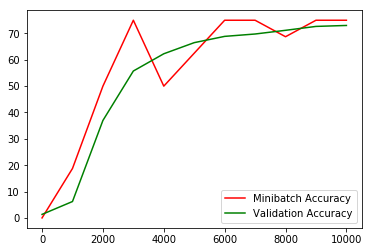

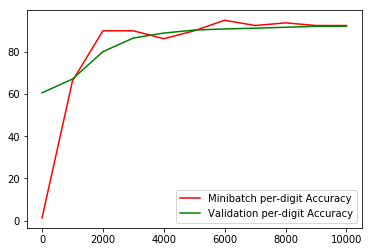

In [40]:
plt.plot(range(0,num_steps+1,1000),minib_acc,'-r',label='Minibatch Accuracy')
plt.plot(range(0,num_steps+1,1000),valid_acc,'-g', label='Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(range(0,num_steps+1,1000),minib_dig_acc,'-r',label='Minibatch per-digit Accuracy')
plt.plot(range(0,num_steps,1000),valid_dig_acc,'-g', label='Validation per-digit Accuracy')
plt.legend()

We obtain around 81% of accuracy for full number recognition, and 93% for individual digits. Note that with a batch size of 16, it takes only about 2000 iterations to visit the whole training set.

Let us now try to use the extra training set to increase the size of our training set. 

In [68]:
extra_set, extra_labels = image_preprocessing(extra_data,extra_folder)

In [69]:
dataset = np.concatenate([dataset,extra_set],axis=0)
labels = np.concatenate([labels,extra_labels],axis=0)
print("DataSet shape : %d x %d x %d x %d" %(dataset.shape[0],dataset.shape[1],dataset.shape[2],dataset.shape[3]))
print("Labels shape : %d x %d " %(labels.shape[0],labels.shape[1]))

DataSet shape : 235754 x 32 x 32 x 1
Labels shape : 235754 x 5 


In [70]:
indices = np.random.permutation(dataset.shape[0])
training_idx, valid_idx = indices[10000:], indices[:10000]
train_dataset, valid_dataset = dataset[training_idx,:,:,:], dataset[valid_idx,:,:,:]
train_labels, valid_labels = labels[training_idx,:], labels[valid_idx,:]

With this setup, the training set has ~226000 training images. The computation time per iteration will not be shorter, but it will takes more iterations to visit the whole training set.

In [71]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_labels = 11
max_num_digits = 5
num_hidden_1 = 128
num_hidden_2 = 64
num_channels = 1 # Number of numbers to characterize each pixel. Here we have grey/white pictures, hence 1. 
lam = 0.01*batch_size/train_dataset.shape[0]
keep_prob=0.8
graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE , num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  #layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.01))
  layer1_biases = tf.Variable(tf.constant(0.0, shape=[depth1]))
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  #layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.01))
  layer2_biases = tf.Variable(tf.constant(0.0, shape=[depth2]))
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, depth3],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  #layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev=0.01))
  layer3_biases = tf.Variable(tf.constant(0.0, shape=[depth3]))
  layer4_weights = tf.get_variable("W4", shape=[IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * depth3, num_hidden_1],\
           initializer=tf.contrib.layers.xavier_initializer())
  layer4_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden_1]))
  layer5_weights = tf.get_variable("W5", shape=[num_hidden_1, num_hidden_2],\
           initializer=tf.contrib.layers.xavier_initializer())
  layer5_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden_2]))

  out1_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out1_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out2_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out2_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out3_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out3_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out4_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out4_b = tf.Variable(tf.zeros(shape=[num_labels]))
  out5_w = tf.Variable(tf.zeros(shape=[num_hidden_2, num_labels]))
  out5_b = tf.Variable(tf.zeros(shape=[num_labels]))

  # Model.
  def model(data,keep_prob=keep_prob):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding = 'SAME')
    relu1 = tf.nn.local_response_normalization(tf.nn.relu(conv1 + layer1_biases))    
    pool1 = tf.nn.dropout(tf.nn.max_pool(relu1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'),keep_prob)
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding = 'SAME')
    relu2 = tf.nn.local_response_normalization(tf.nn.relu(conv2 + layer2_biases))
    pool2 = tf.nn.dropout(tf.nn.max_pool(relu2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'),keep_prob)
    conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, 1, 1, 1], padding = 'SAME')
    relu3 = tf.nn.local_response_normalization(tf.nn.relu(conv3 + layer3_biases))
    pool3 = tf.nn.dropout(tf.nn.max_pool(relu3, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'),keep_prob)
    shape = pool3.get_shape().as_list()
    reshape = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape,layer4_weights)+layer4_biases),keep_prob)
    hidden_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden_1,layer5_weights)+layer5_biases),keep_prob)
    logits1 = tf.matmul(hidden_2, out1_w) + out1_b
    logits2 = tf.matmul(hidden_2, out2_w) + out2_b
    logits3 = tf.matmul(hidden_2, out3_w) + out3_b
    logits4 = tf.matmul(hidden_2, out4_w) + out4_b
    logits5 = tf.matmul(hidden_2, out5_w) + out5_b
    
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)    
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits1, labels = tf_train_labels[:,0])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits2, labels = tf_train_labels[:,1])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits3, labels = tf_train_labels[:,2])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits4, labels = tf_train_labels[:,3])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits5, labels = tf_train_labels[:,4])) +\
         lam*(tf.nn.l2_loss(layer1_weights)+tf.nn.l2_loss(layer2_weights)+tf.nn.l2_loss(layer3_weights)
              +tf.nn.l2_loss(layer4_weights)+tf.nn.l2_loss(layer5_weights))

  # Optimizer.
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.98,staircase=True)
  optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss,global_step=global_step)  
 
  # Predictions for the training, validation, and test data. Note : no dropout at prediction time!
  train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[0]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[1]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[2]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[3]),\
                               tf.nn.softmax(model(tf_train_dataset,keep_prob=1.0)[4])])
  valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[0]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[1]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[2]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[3]),\
                               tf.nn.softmax(model(tf_valid_dataset,keep_prob=1.0)[4])])
  test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[0]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[1]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[2]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[3]),\
                              tf.nn.softmax(model(tf_test_dataset,keep_prob=1.0)[4])])

In [72]:
num_steps = 40001
minib_acc = []
valid_acc = []
minib_dig_acc = []
valid_dig_acc = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      valid_pred = valid_prediction.eval()  
      score_minib = accuracy(predictions, batch_labels)
      score_dig_minib = digit_accuracy(predictions, batch_labels)
      score_valid = accuracy(valid_pred, valid_labels)
      score_dig_valid = digit_accuracy(valid_pred, valid_labels)
      minib_acc.append(score_minib)
      valid_acc.append(score_valid)
      minib_dig_acc.append(score_dig_minib)
      valid_dig_acc.append(score_dig_valid)
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % score_minib)
      print('Validation accuracy: %.1f%%' % score_valid)
      print('Minibatch char accuracy: %.1f%%' % score_dig_minib)
      print('Validation char accuracy: %.1f%%' % score_dig_valid) 
  test_pred = test_prediction.eval()  
  print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))
  print('Test char accuracy: %.1f%%' % digit_accuracy(test_pred, test_labels))

Initialized
Minibatch loss at step 0: 11.990015
Minibatch accuracy: 0.0%
Validation accuracy: 0.7%
Minibatch char accuracy: 3.1%
Validation char accuracy: 54.7%
Minibatch loss at step 1000: 3.920633
Minibatch accuracy: 26.6%
Validation accuracy: 28.4%
Minibatch char accuracy: 77.8%
Validation char accuracy: 77.8%
Minibatch loss at step 2000: 2.297165
Minibatch accuracy: 65.6%
Validation accuracy: 62.1%
Minibatch char accuracy: 90.9%
Validation char accuracy: 89.3%
Minibatch loss at step 3000: 1.807859
Minibatch accuracy: 71.9%
Validation accuracy: 72.2%
Minibatch char accuracy: 92.8%
Validation char accuracy: 92.1%
Minibatch loss at step 4000: 1.680629
Minibatch accuracy: 78.1%
Validation accuracy: 76.8%
Minibatch char accuracy: 94.1%
Validation char accuracy: 93.6%
Minibatch loss at step 5000: 1.889567
Minibatch accuracy: 67.2%
Validation accuracy: 79.0%
Minibatch char accuracy: 91.6%
Validation char accuracy: 94.2%
Minibatch loss at step 6000: 1.414639
Minibatch accuracy: 81.2%
Valid

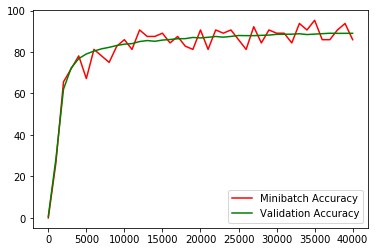

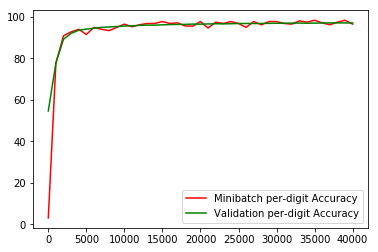

In [73]:
plt.plot(range(0,num_steps+1,1000),minib_acc,'-r',label='Minibatch Accuracy')
plt.plot(range(0,num_steps,1000),valid_acc,'-g', label='Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(range(0,num_steps+1,1000),minib_dig_acc,'-r',label='Minibatch per-digit Accuracy')
plt.plot(range(0,num_steps,1000),valid_dig_acc,'-g', label='Validation per-digit Accuracy')
plt.legend()

## References :

[1] *Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks*, Ian J. Goodfellow, Yaroslav Bulatov, Julian Ibarz, Sacha Arnoud, Vinay Shet.

[2] *Practical recommendations for gradient-based training of deep architectures*, Y. Bengio, arXiv:1206.5533.
